# Model Report

In [21]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
from analysis import color_pal as pal
from analysis import common_data_processing as dphelp
from analysis import pymc3_analysis as pmanal
from analysis import pymc3_sampling_api as pmapi
from analysis.pymc3_models import crc_models

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

Parameters for papermill:

- `MODEL_CACHE_DIR`: location of cache
- `MODEL`: which model was tested
- `DEBUG`: if in debug mode or not

## Setup

### Papermill parameters

In [22]:
MODEL_CACHE_DIR = "analysis/pymc3_model_cache/CRC-model1"
MODEL = "crc-m1"
DEBUG = True

### Data

In [23]:
if DEBUG:
    data_path = Path("..", "modeling_data", "depmap_CRC_data_subsample.csv")
else:
    data_path = Path("..", "modeling_data", "depmap_CRC_data.csv")

data = dphelp.read_achilles_data(data_path)
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


### Model

> For conversion to parameterized notebook, I may need to refactor "sampling_pymc3_models.py" to be able to pass arguments without using the CLI. For instance, I would want to be able to use the same model generation function just by passing the string `"crc-m1"`, but I wouldn't want to sample the model.

In [24]:
indices_dict = dphelp.common_indices(data)

model, shared_vars = crc_models.model_1(
    sgrna_idx=indices_dict["sgrna_idx"],
    sgrna_to_gene_idx=indices_dict["sgrna_to_gene_idx"],
    cellline_idx=indices_dict["cellline_idx"],
    batch_idx=indices_dict["batch_idx"],
    lfc_data=data.lfc.values,
)

model_res = pmapi.read_cached_vi(MODEL_CACHE_DIR)

model_az = az.from_pymc3(
    trace=model_res["trace"],
    model=model,
    posterior_predictive=model_res["posterior_predictive"],
    prior=model_res["prior_predictive"],
)

Loading cached trace and posterior sample...


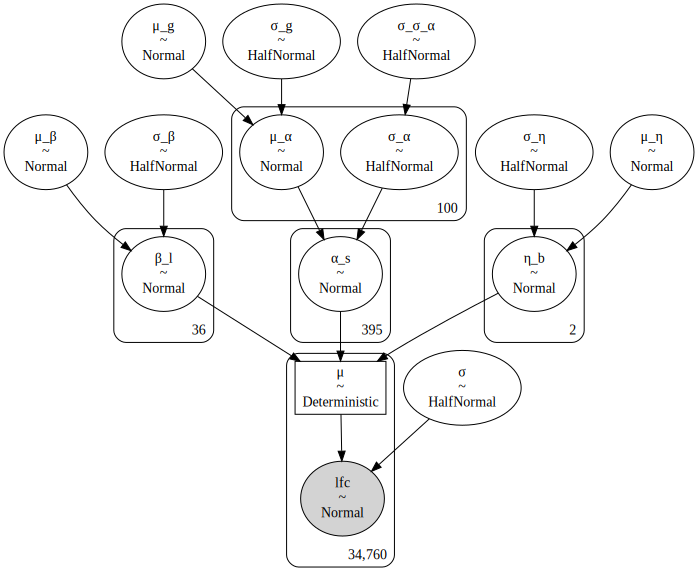

In [25]:
pm.model_to_graphviz(model)

## Fit diagnostics

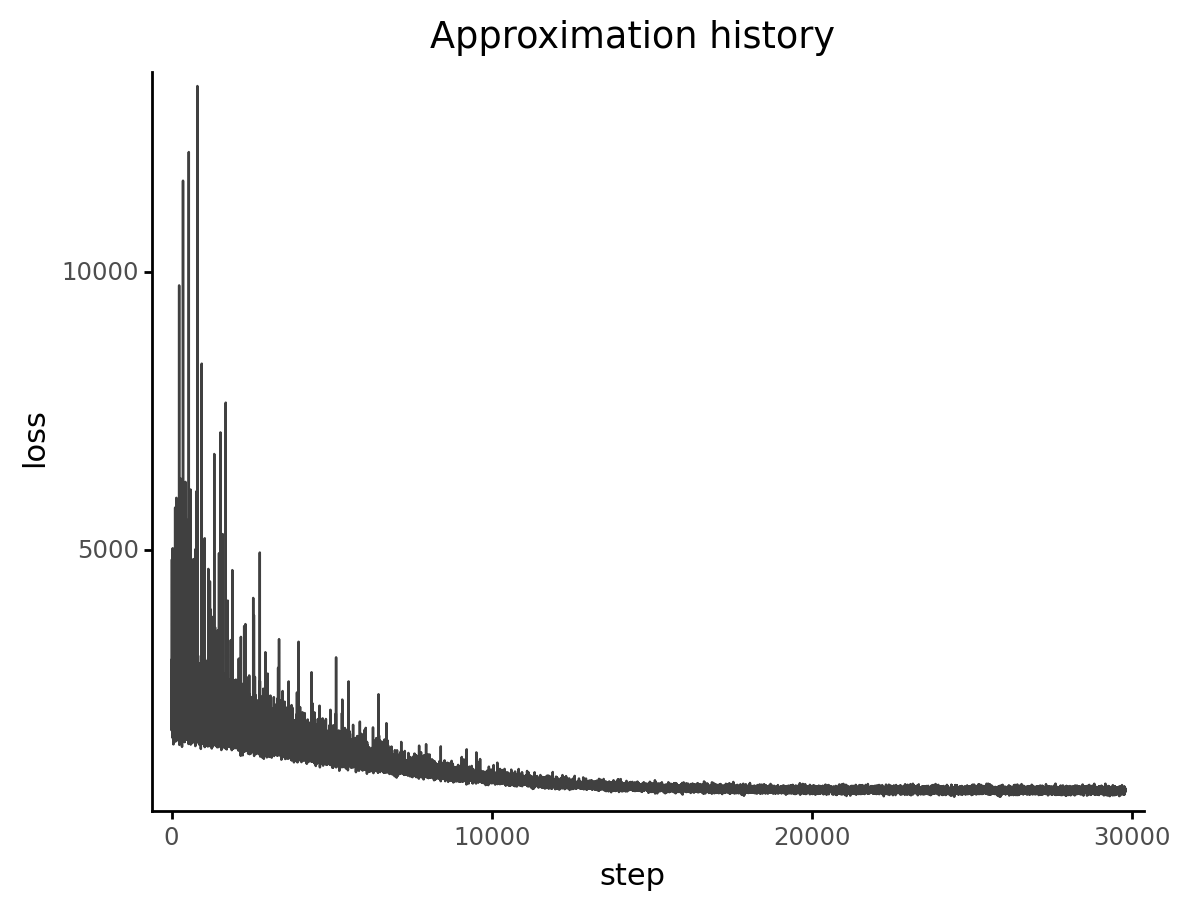

<ggplot: (8770026000035)>

In [26]:
pmanal.plot_vi_hist(model_res["approximation"])

## Model parameters

In [27]:
def check_shape(trace: np.ndarray) -> np.ndarray:
    if len(trace.shape) == 1:
        return trace[:, None]
    return trace


def add_hdi(p: gg.ggplot, values: np.ndarray, color: str) -> gg.ggplot:
    m = np.mean(values)
    hdi = az.hdi(values, hdi_prob=0.89).flatten()
    p = (
        p
        + gg.geom_vline(xintercept=m, color=color)
        + gg.geom_vline(xintercept=hdi, color=color, linetype="--")
    )
    return p


def variable_distribution_plot(var, trace: np.ndarray, max_plot=20000) -> gg.ggplot:
    trace = check_shape(trace)

    # Sample 25% of the trace.
    d = pd.DataFrame(trace).melt().assign(variable=lambda d: d.variable.astype("str"))
    d_summaries = d.groupby(["variable"])["value"].mean().reset_index(drop=False)

    if d.shape[0] > max_plot:
        d = d.sample(n=max_plot)
    else:
        d = d.sample(frac=0.2)

    p = (
        gg.ggplot(d, gg.aes(x="value"))
        + gg.geom_density(alpha=0.1)
        + gg.geom_vline(xintercept=0, color="black", size=0.7, alpha=0.7, linetype="--")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(legend_position="none", figure_size=(6.5, 3))
        + gg.labs(x="posterior", y="density", title=f"Posterior distirbution of {var}")
    )

    c = pal.sns_blue

    if len(d_summaries) > 1:
        p = p + gg.geom_rug(
            data=d_summaries, sides="b", alpha=0.5, color=c, length=0.08
        )
    else:
        p = add_hdi(p, trace.flatten(), color=c)

    return p

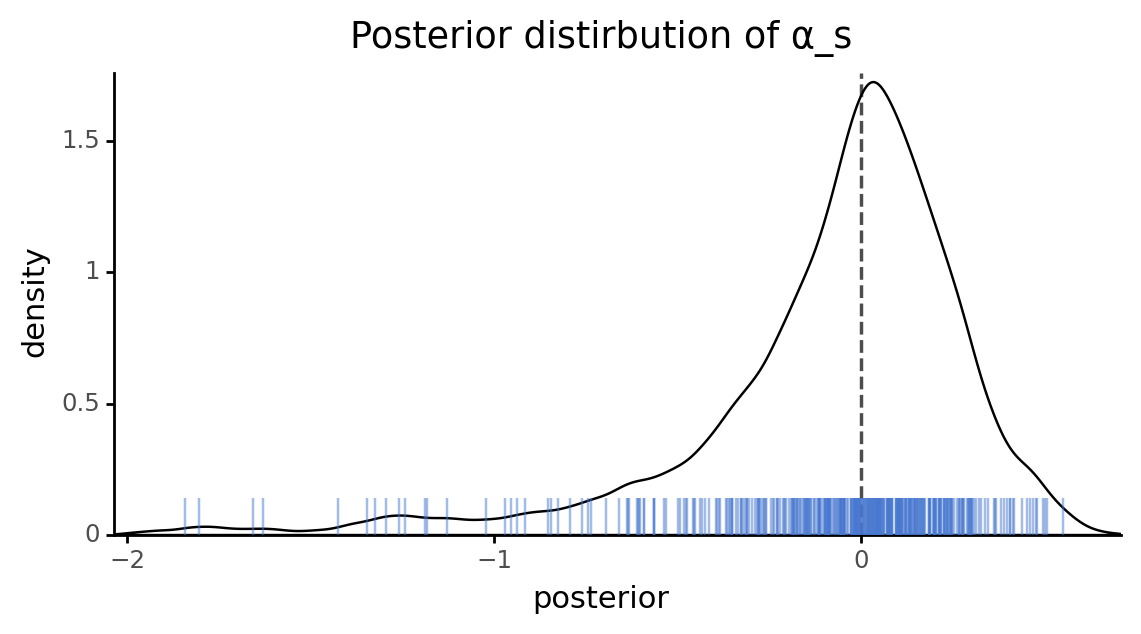

<ggplot: (8770016135461)>


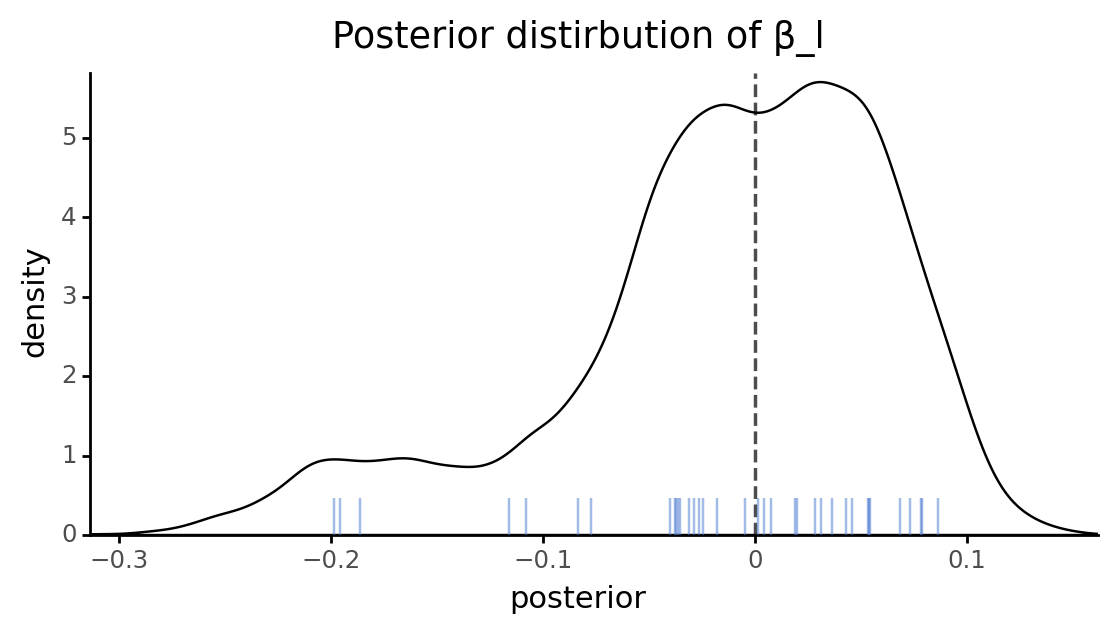

<ggplot: (8770014826900)>


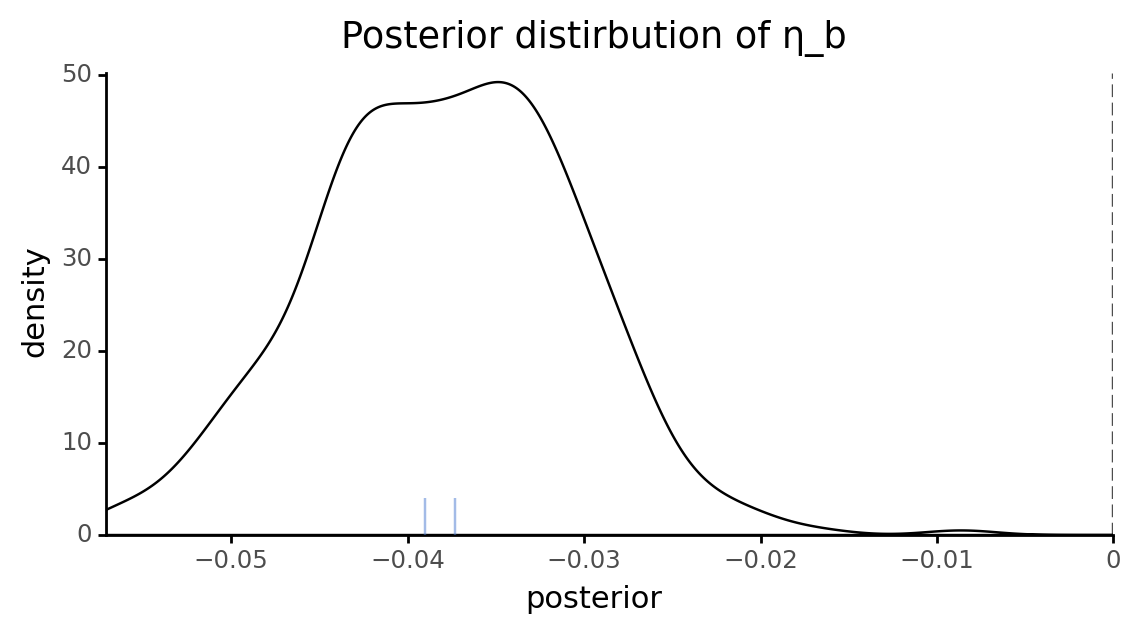

<ggplot: (8770016351687)>


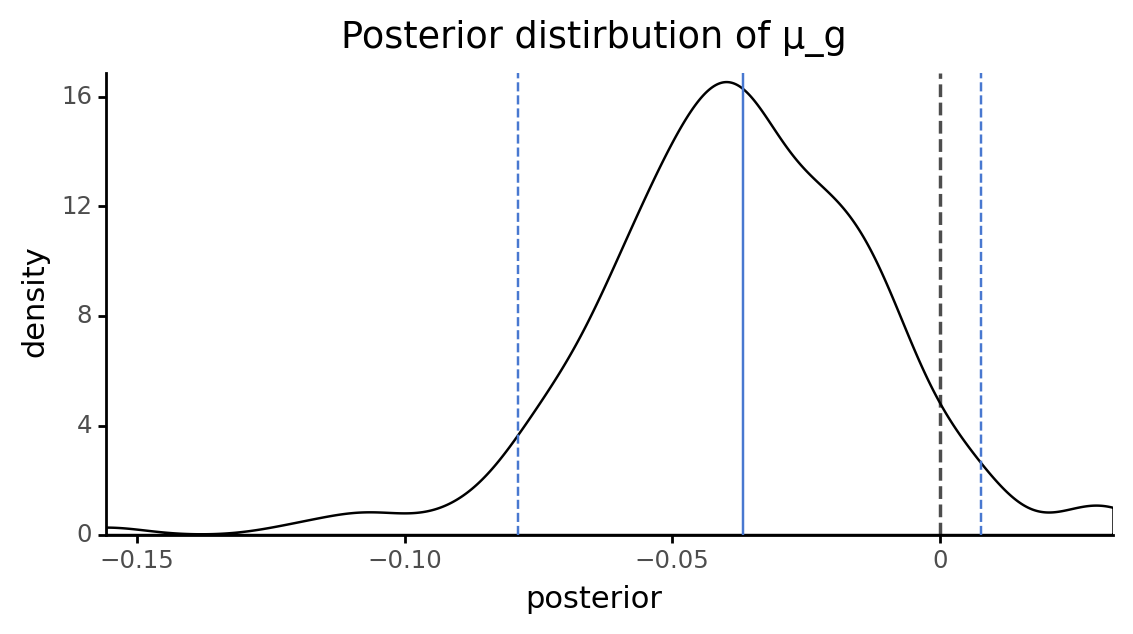

<ggplot: (8770015799938)>


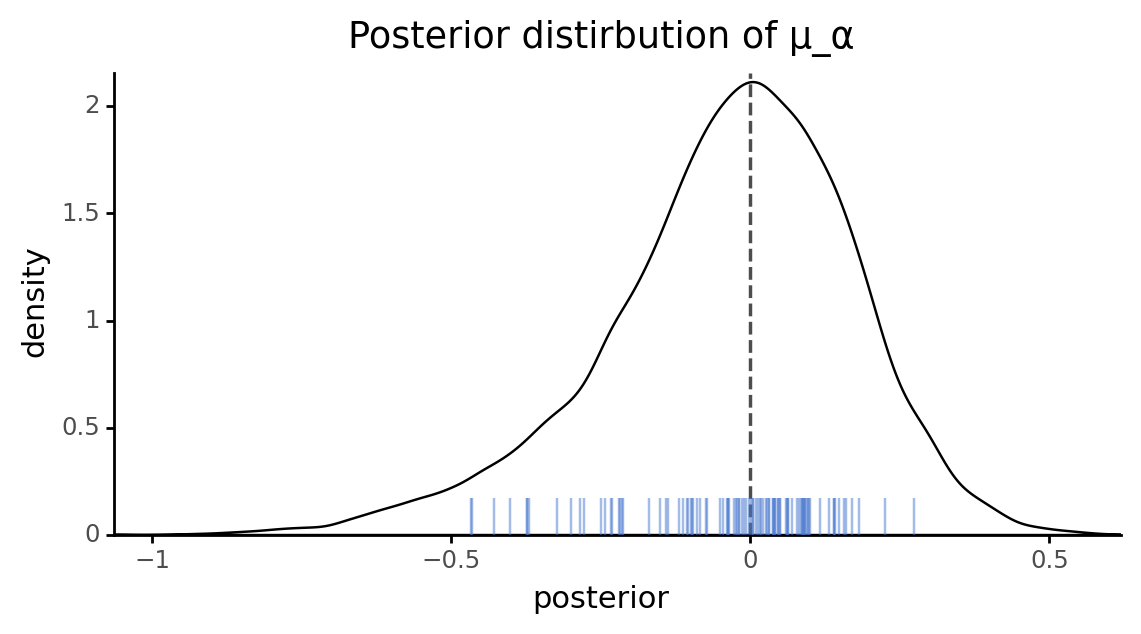

<ggplot: (8770016237138)>


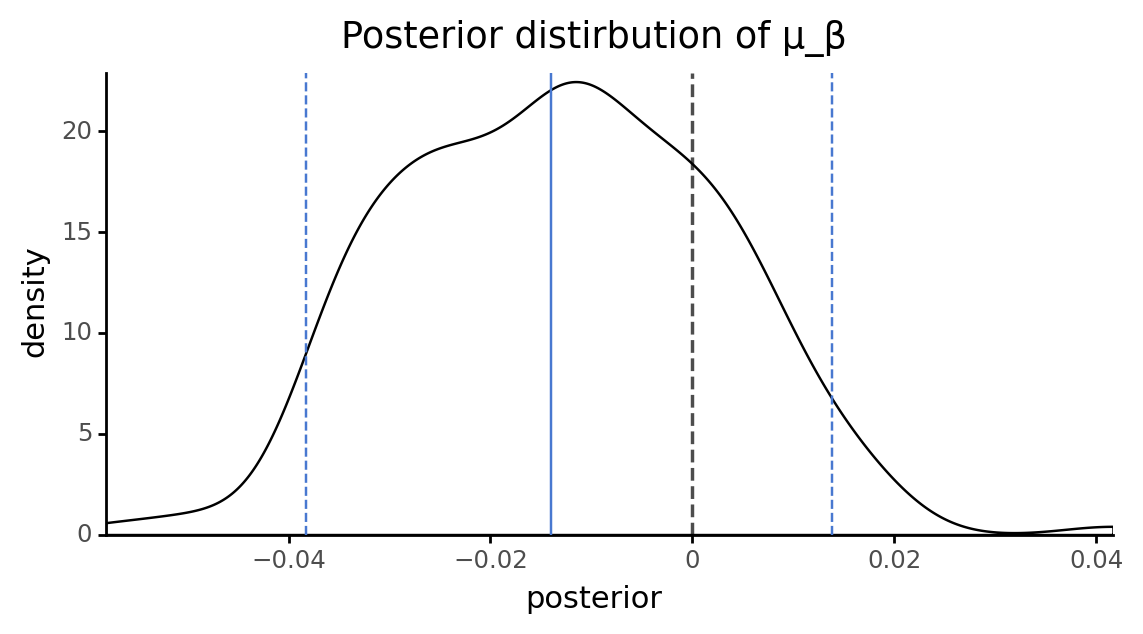

<ggplot: (8770016083339)>


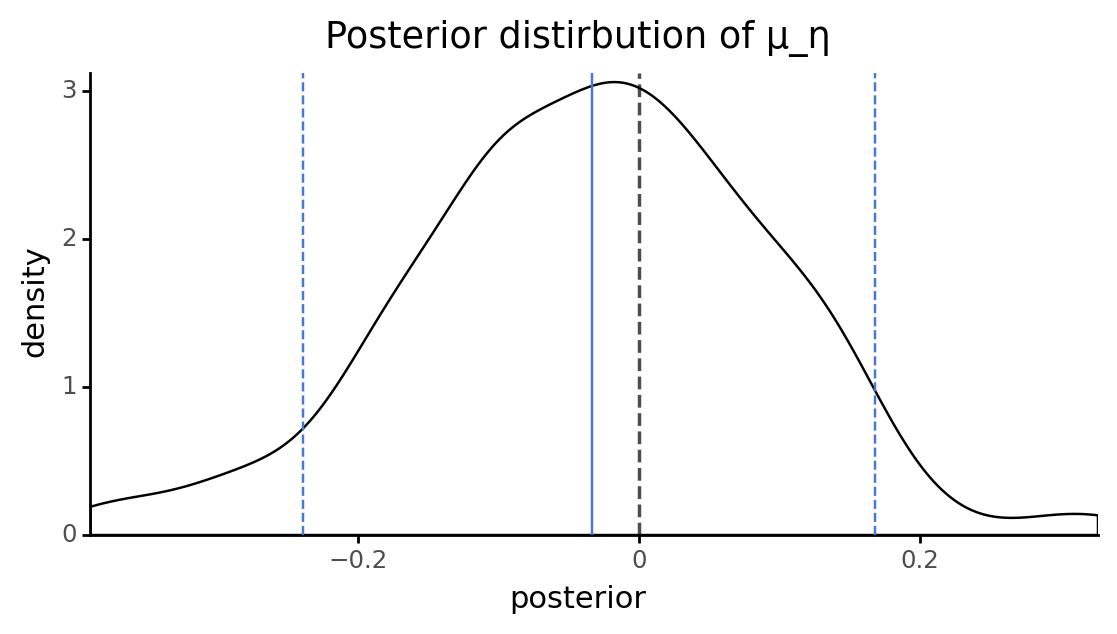

<ggplot: (8770016256741)>


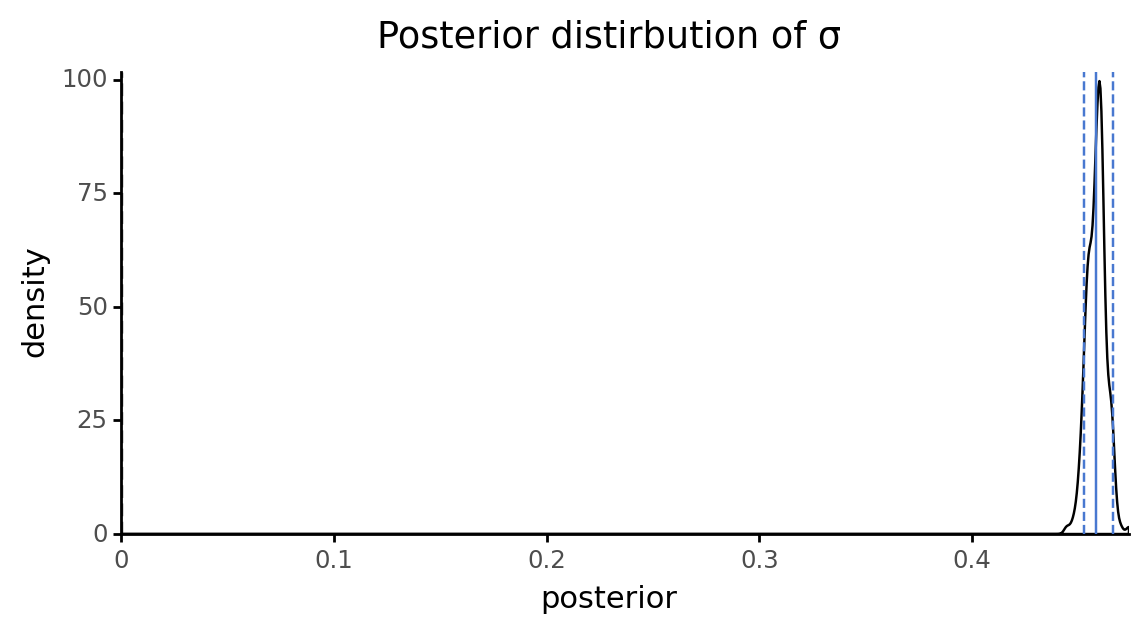

<ggplot: (8770016207144)>


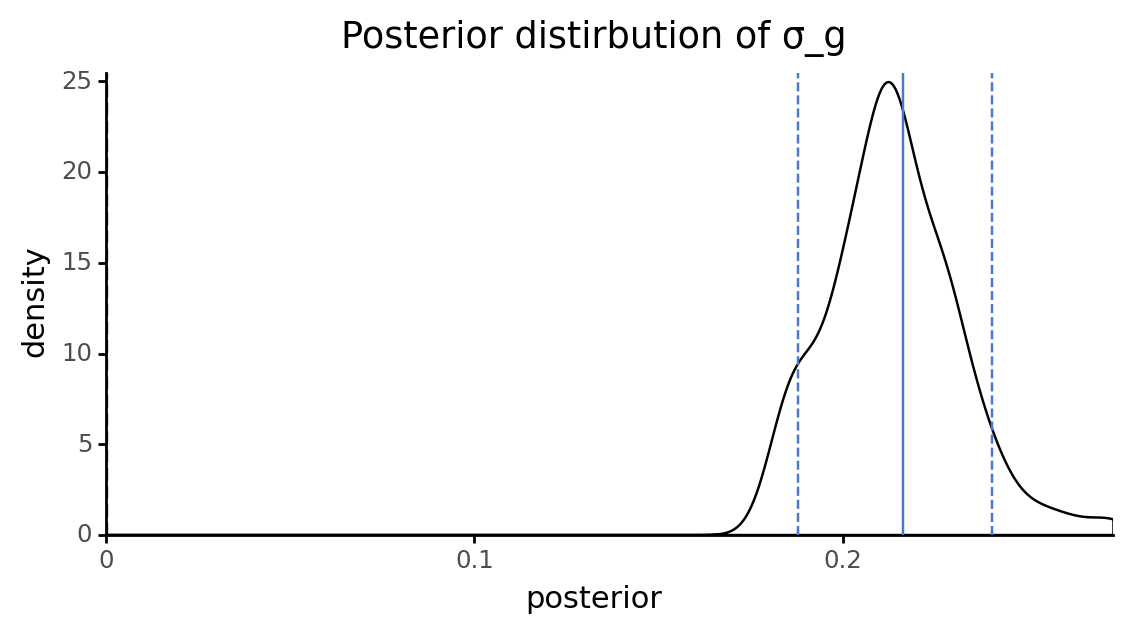

<ggplot: (8770014861590)>


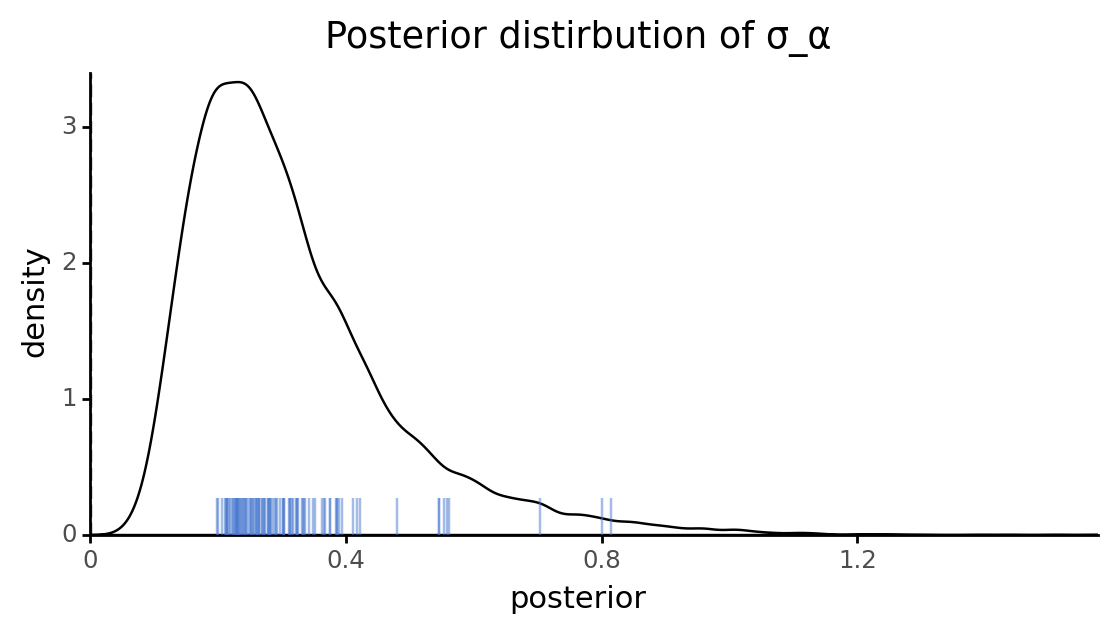

<ggplot: (8770015178500)>


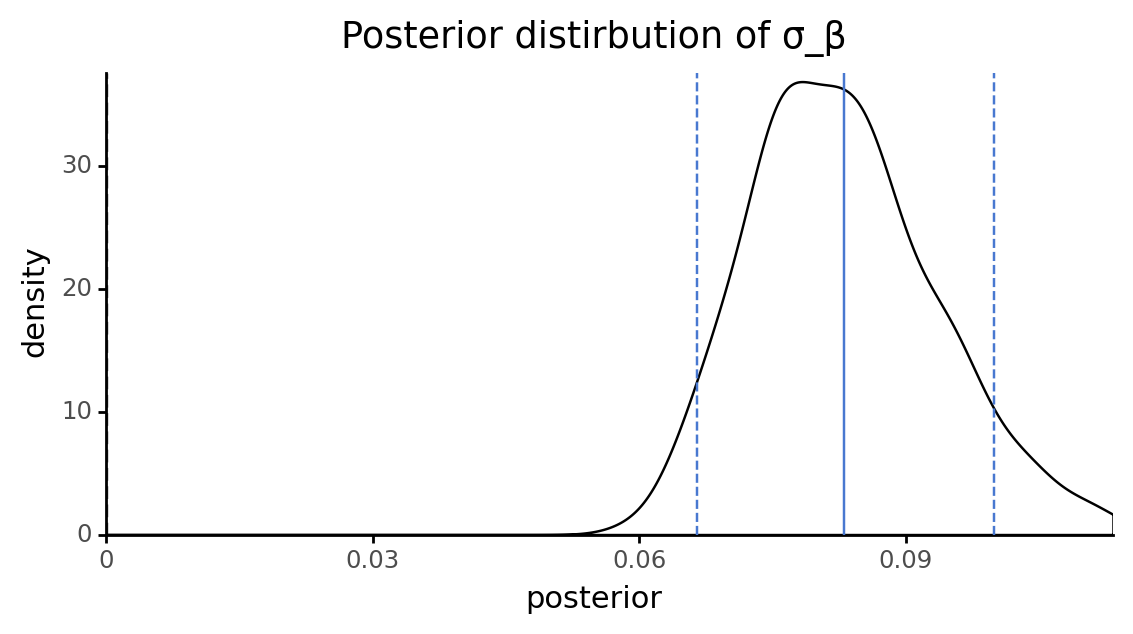

<ggplot: (8770016205373)>


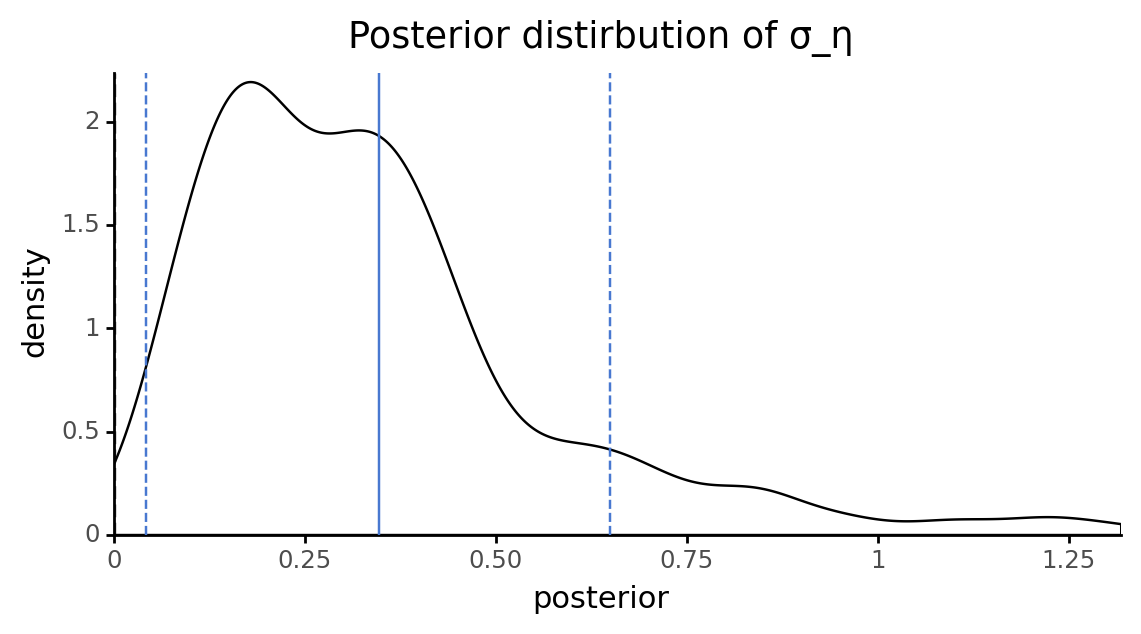

<ggplot: (8770014772896)>


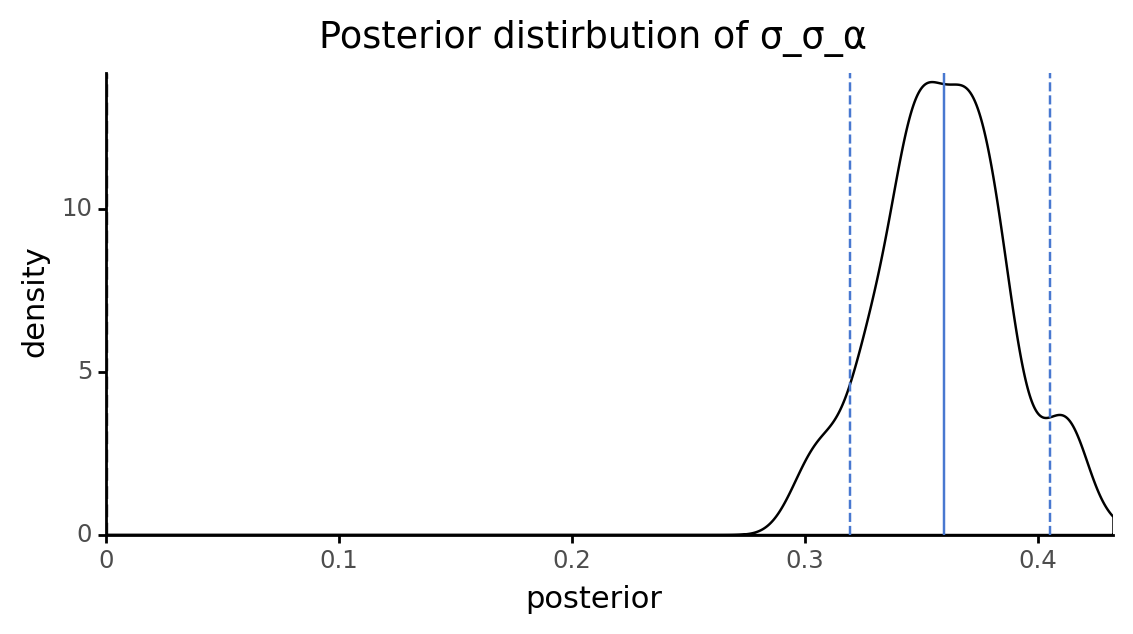

<ggplot: (8770014998821)>


In [28]:
vars_to_inspect = model_res["trace"].varnames
vars_to_inspect = [v for v in vars_to_inspect if not "log" in v]
vars_to_inspect.sort()

for var in vars_to_inspect:
    trace = model_res["trace"][var]
    if len(trace.shape) > 1 and trace.shape[1] == data.shape[0]:
        # Do not plot the final deterministic mean (usually "μ").
        continue
    print(variable_distribution_plot(var, model_res["trace"][var]))

## Model predicitons

In [29]:
predictions = model_res["posterior_predictive"]
pred_summary = pmanal.summarize_posterior_predictions(
    predictions["lfc"],
    merge_with=data[["lfc", "depmap_id", "hugo_symbol", "sgrna", "log2_cn"]],
)
pred_summary["error"] = pred_summary.lfc - pred_summary.pred_mean
pred_summary.head()

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,lfc,depmap_id,hugo_symbol,sgrna,log2_cn,error
0,-0.147115,-0.802405,0.609533,0.029491,ACH-000007,ADAMTS13,CCACCCACAGACGCTCAGCA,1.861144,0.176607
1,-0.147575,-0.907226,0.628692,0.426017,ACH-000007,ADAMTS13,CCACCCACAGACGCTCAGCA,1.861144,0.573592
2,-0.058426,-0.870740,0.655768,0.008626,ACH-000009,ADAMTS13,CCACCCACAGACGCTCAGCA,1.375470,0.067052
3,-0.045138,-0.762936,0.699539,0.280821,ACH-000009,ADAMTS13,CCACCCACAGACGCTCAGCA,1.375470,0.325959
4,-0.066573,-0.828162,0.687034,0.239815,ACH-000009,ADAMTS13,CCACCCACAGACGCTCAGCA,1.375470,0.306389


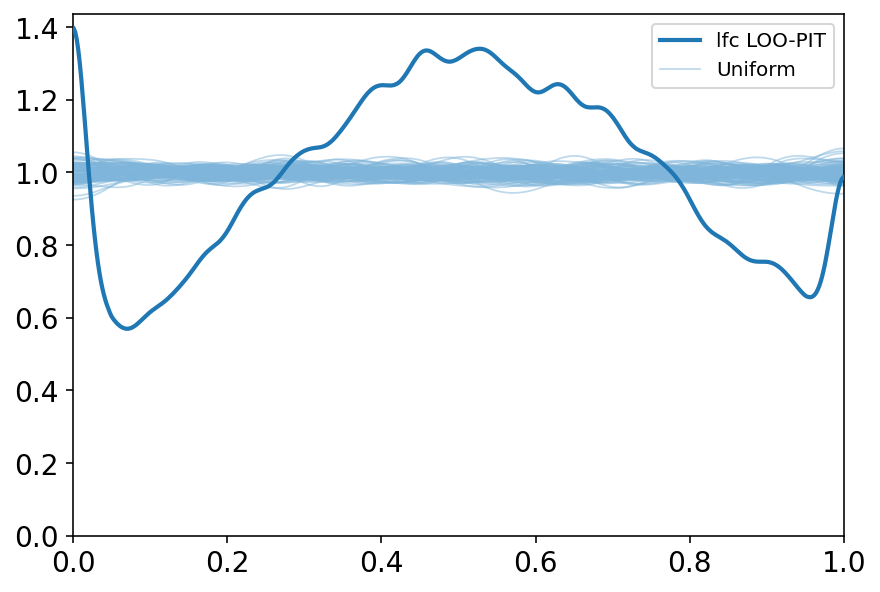

In [30]:
az.plot_loo_pit(model_az, y="lfc");

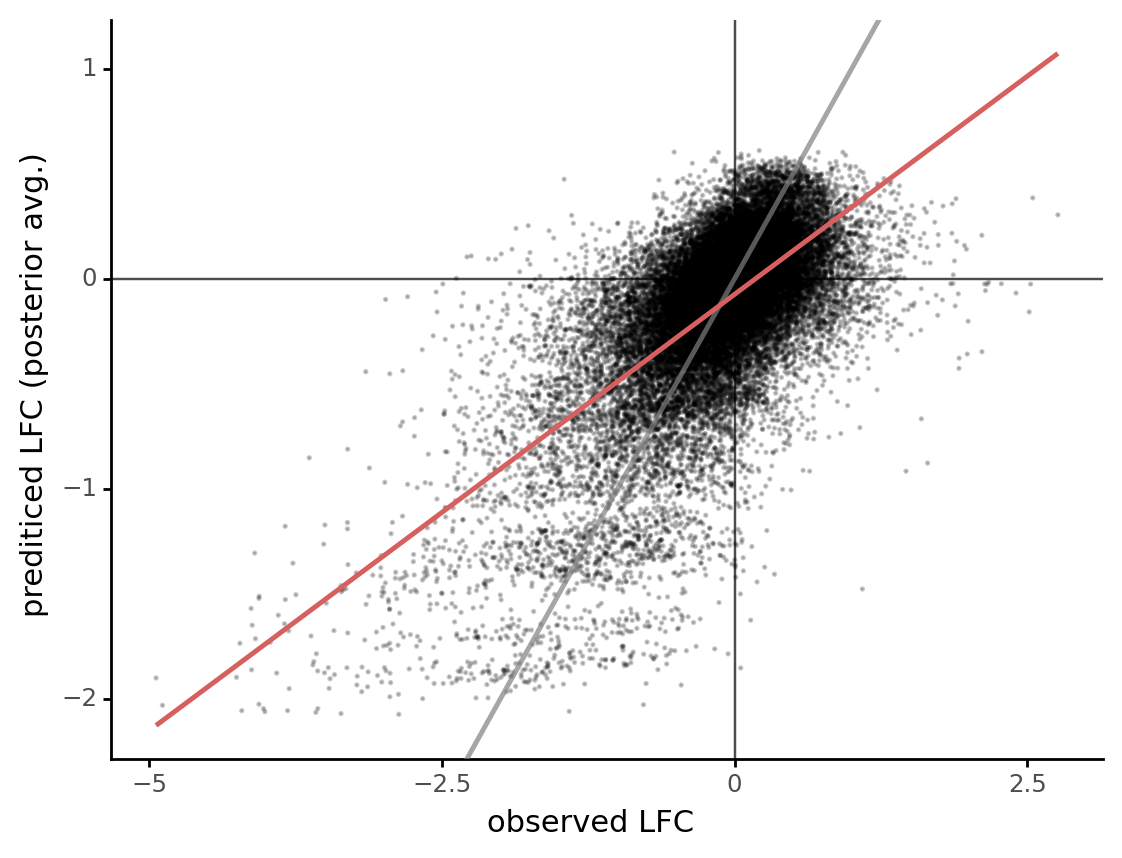

<ggplot: (8770021275094)>

In [31]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.geom_abline(slope=1, intercept=0, size=1, alpha=0.7, color="grey")
    + gg.geom_smooth(method="glm", color=pal.sns_red, size=1, alpha=0.7, se=False)
    + gg.labs(x="observed LFC", y="prediticed LFC (posterior avg.)")
)

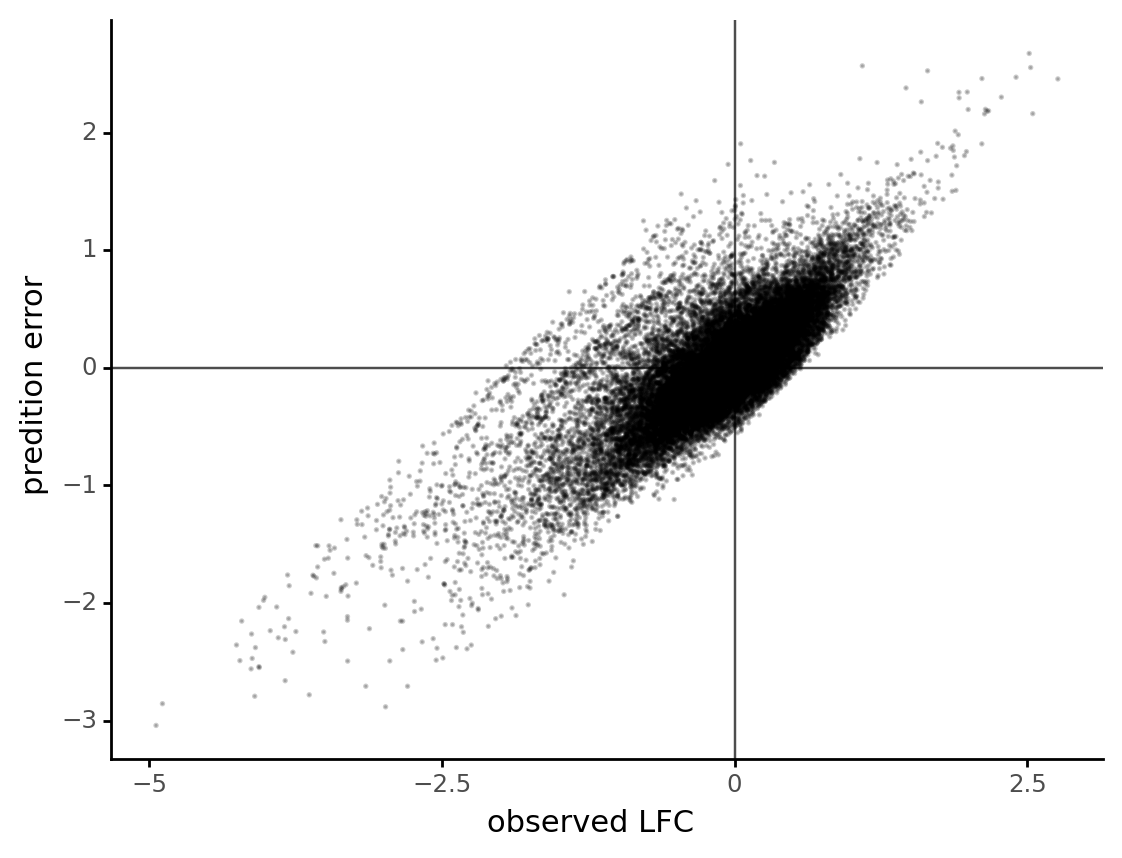

<ggplot: (8770021569711)>

In [32]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="observed LFC", y="prediction error")
)

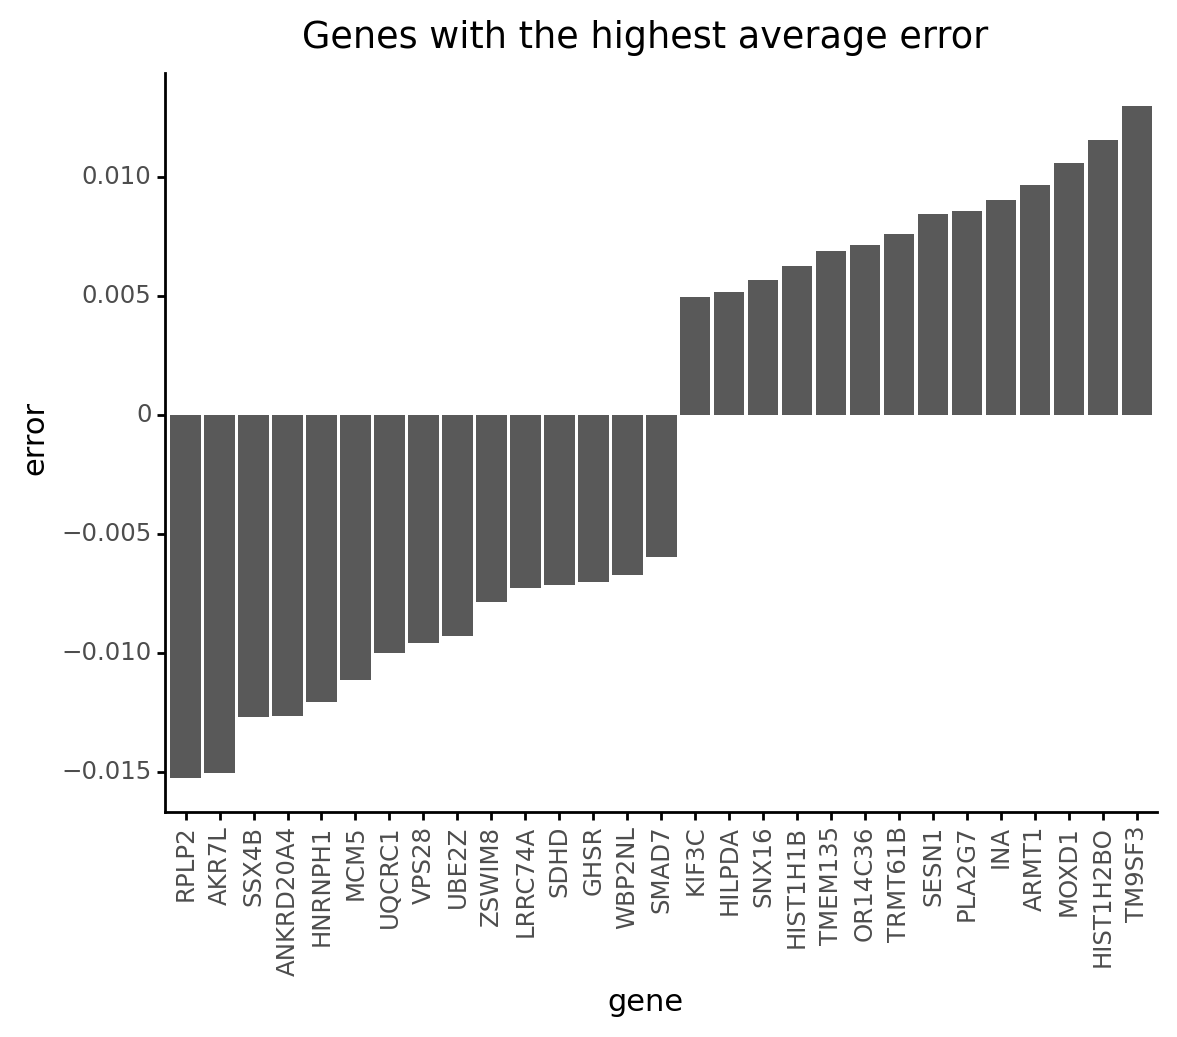

<ggplot: (8770016975487)>

In [33]:
gene_error = (
    pred_summary.groupby(["hugo_symbol"])["error"]
    .agg([np.mean, np.std])
    .reset_index(drop=False)
    .sort_values(["mean"])
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.astype(str),
            categories=d.hugo_symbol.astype(str),
            ordered=True,
        )
    )
)

n_genes = 15

(
    gg.ggplot(
        gene_error.iloc[list(range(n_genes)) + list(range(-n_genes, -1))],
        gg.aes(x="hugo_symbol", y="mean"),
    )
    + gg.geom_col()
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="gene", y="error", title="Genes with the highest average error")
)

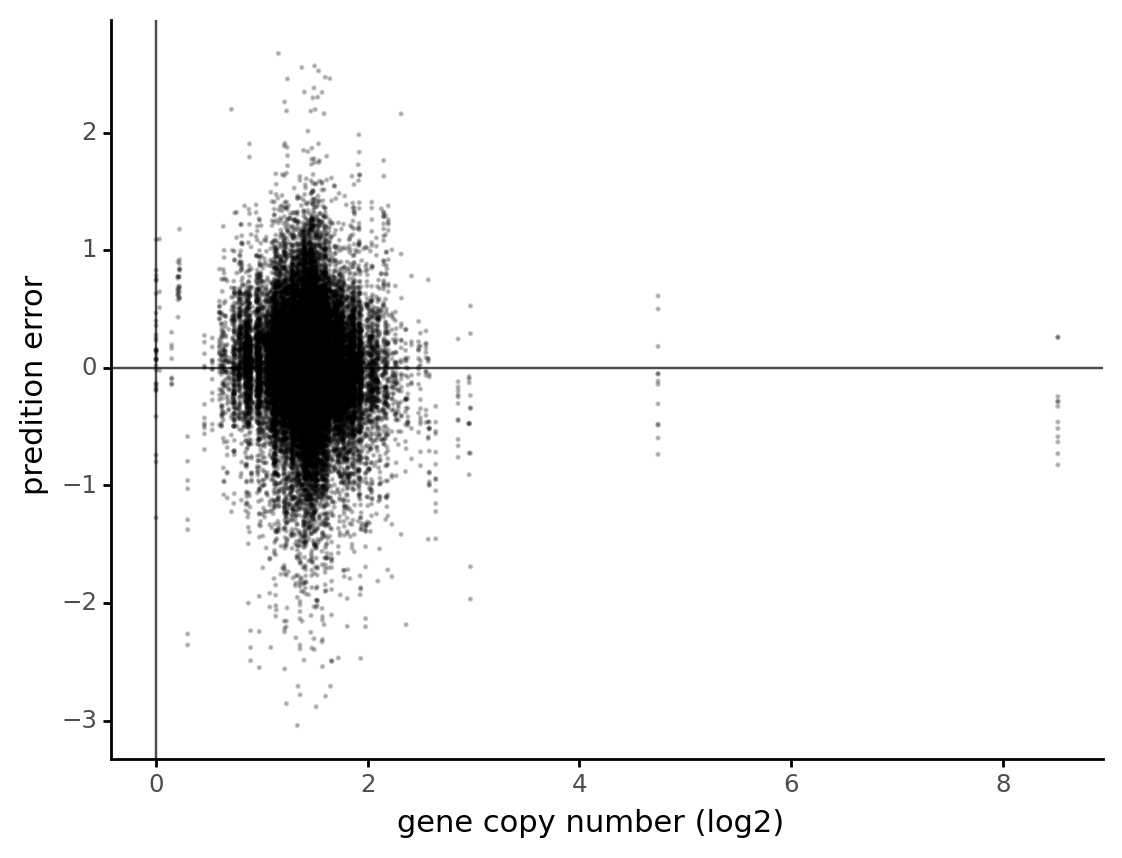

<ggplot: (8770021511527)>

In [34]:
(
    gg.ggplot(pred_summary, gg.aes(x="log2_cn", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="gene copy number (log2)", y="predition error")
)

---

In [35]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.72 minutes


In [36]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-03-10

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: crc-m1

matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.1
plotnine  : 0.7.1
numpy     : 1.20.1
pandas    : 1.2.2

